### Recommender System Based on XGBoost Regressor

#### Import Library

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

#### Load File

In [2]:
# read file
file = pd.read_csv("netflix_rating.csv")
  
# adding header
headerList = ['movie_id', 'customer_id', 'rating', "date"]
  
# converting data frame to csv
file.to_csv("ratings.csv", header=headerList, index=False)
  
    
# display modified csv file
netflix_rating_df = pd.read_csv("ratings.csv")

netflix_rating_df.head()

,movie_id,customer_id,rating,date
0,13368,659432,3,2005-03-16
1,13368,751812,2,2002-12-16
2,13368,2625420,2,2004-05-25
3,13368,1650301,1,2005-08-30
4,13368,2269227,4,2005-10-27


#### Check for the duplicate records

In [3]:
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum()

0

#### Split Data into Train and Test Data

In [4]:
split_value = int(len(netflix_rating_df) * 0.80)

train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

#### Analysis of Data: Count of Ratings - 1, 2, 3, 4, 5

c:\users\sanmilee\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


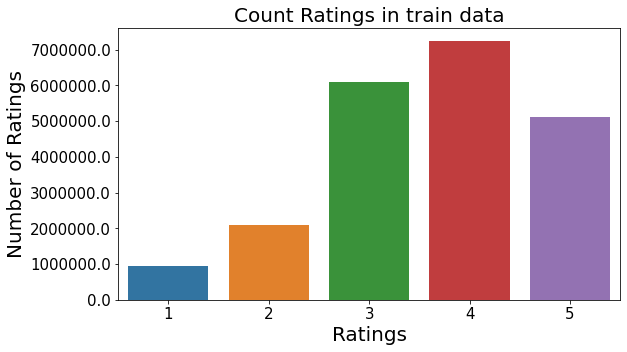

In [5]:
plt.figure(figsize = (9, 5))
ax = sns.countplot(x="rating", data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

#### Create User-Item Sparse Matrix

In [6]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

#### Create Sparse Matrix from the Training Dataset


In [7]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

#### Create Sparse Matrix from the Test Dataset


In [8]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

#### Computation of user similarity to find similarities of top 100 users

In [9]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

In [10]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [11]:
similar_user_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Load Movie Titles Data

In [12]:
movie_titles_df = pd.read_csv("movie_titles.csv", sep = ",",
                              header = None, names=['movie_id', 'year_of_release', 'movie_title'],
                              index_col = "movie_id", encoding = "iso8859_2")


movie_titles_df.head()

,year_of_release,movie_title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


#### Compute Movie Similarity Matrix

In [13]:
def compute_movie_similarity_count(sparse_matrix, movie_titles_df, movie_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    return no_of_similar_movies

In [14]:
similar_movies = compute_movie_similarity_count(train_sparse_data, movie_titles_df, 1)

print("Similar Movies = {}".format(similar_movies))

Similar Movies = ('Dinosaur Planet', 0)


#### Create Sample Sparse Matrix
- This method will be used to generate Sample Sparse Matrix. New similarity features will be generated from this sample sparse matrix.

In [15]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

#### Sample Sparse Matrix for the Traning Data

In [16]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

#### Sample Sparse Matrix for the Test Data

In [17]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

#### Calculate Average Rating from Sparse Matrix

In [18]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    
    return average_ratings

#### Calculate Average User Rating


In [19]:
average_rating_user = get_average_rating(train_sparse_data, True)

# display avarage rating for movieid 6
average_rating_user[6]

3.4285714285714284

#### Calcualte Average Movie Rating


In [20]:
avg_rating_movie = get_average_rating(train_sparse_data, False)

avg_rating_movie[13368]

3.547528517110266

#### A Generic Method to Generate Similar Featuires: This will generate below similar features:

- similar_user_rating1
- similar_user_rating2
- similar_user_rating3
- similar_user_rating4
- similar_user_rating5
- similar_movie_rating1
- similar_movie_rating2
- similar_movie_rating3
- similar_movie_rating4
- similar_movie_rating5

In [21]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_movie_rating1", "similar_movie_rating2", 
                                                               "similar_movie_rating3", "similar_movie_rating4", 
                                                               "similar_movie_rating5", "user_average", 
                                                               "movie_average", "rating"])
    return new_features_df

#### Generate Similar Features for the Training Data

In [22]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [23]:
train_new_similar_features = train_new_similar_features.fillna(0)

train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,368756,13393,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
1,2593137,13495,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
2,96842,13602,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0
3,486048,13602,3.392157,3.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,4.5,3.0,0.0,0.0
4,940434,13602,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0


#### Train Data

In [24]:
x_train = train_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

y_train = train_new_similar_features["rating"]

In [35]:
x_train.head()

,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average
0,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0
1,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0
2,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0
3,3.392157,3.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,4.5,3.0,0.0
4,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0


#### Generate Similar Features for the Test Data

In [25]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [26]:
test_new_similar_features = test_new_similar_features.fillna(0)

test_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,218348,16977,3.393939,4,1.0,5.0,4.0,3.0,5.0,5.0,5.000000,5.000000,5.000000,5.000000,3.583333,5.0
1,482111,16977,3.393939,4,1.0,5.0,4.0,3.0,3.0,3.0,3.000000,3.000000,3.000000,3.000000,3.583333,3.0
2,770495,16977,3.393939,4,1.0,5.0,4.0,3.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.583333,4.0
3,1033930,16977,3.393939,2,1.0,3.0,4.0,4.0,3.0,2.0,2.666667,2.666667,2.666667,2.666667,3.583333,3.0
4,1301848,16977,3.393939,4,1.0,5.0,4.0,3.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.583333,4.0


#### Test Data

In [27]:
x_test = test_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

y_test = test_new_similar_features["rating"]

In [36]:
x_test.head()

,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average
0,3.393939,4,1.0,5.0,4.0,3.0,5.0,5.0,5.000000,5.000000,5.000000,5.000000,3.583333
1,3.393939,4,1.0,5.0,4.0,3.0,3.0,3.0,3.000000,3.000000,3.000000,3.000000,3.583333
2,3.393939,4,1.0,5.0,4.0,3.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.583333
3,3.393939,2,1.0,3.0,4.0,4.0,3.0,2.0,2.666667,2.666667,2.666667,2.666667,3.583333
4,3.393939,4,1.0,5.0,4.0,3.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.583333


#### Define XGBoot Regressor Model

In [28]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)

clf.fit(x_train, y_train)

[00:15:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=10, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

#### Check Model Performance on Test Set

In [29]:
y_pred_test = clf.predict(x_test)

In [30]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [31]:
print("MAE: {:.4f}".format(mean_absolute_error(y_test, y_pred_test)))
print()
print("MSE: {:.4f}".format(mean_squared_error(y_test, y_pred_test)))
print()
print("RMSE: {:.4f}".format(error_metrics(y_test, y_pred_test)))
print()
print("R2 Error: {:.4f}".format(r2_score(y_test, y_pred_test)))

MAE: 0.1913

MSE: 0.2074

RMSE: 0.4554

R2 Error: 0.9342


#### Plot Feature Importance

In [32]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

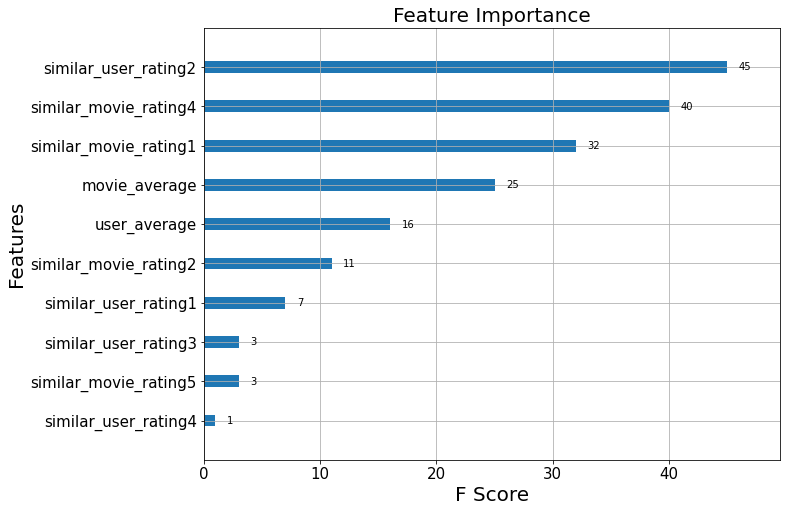

In [33]:
plot_importance(xgb, clf)